1. [x] Frame the problem and look at the big picture.
2. [x] Get the data.
3. [x] Explore the data to gain insights.
4. [x] Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.
5. [x] Explore many different models and short-list the best ones.
6. [x] Fine-tune your models and combine them into a great solution.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings('ignore')

# Read training data

In [3]:
df = pd.read_csv("data/train.csv")

In [4]:
# Original data structure
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Categorical features distinct values

In [6]:
print("Number of unique values for each categorical feature")
for feature in df.select_dtypes(include="object").columns:
    print(f"{feature}:", df[feature].nunique())

Number of unique values for each categorical feature
Name: 891
Sex: 2
Ticket: 681
Cabin: 147
Embarked: 3


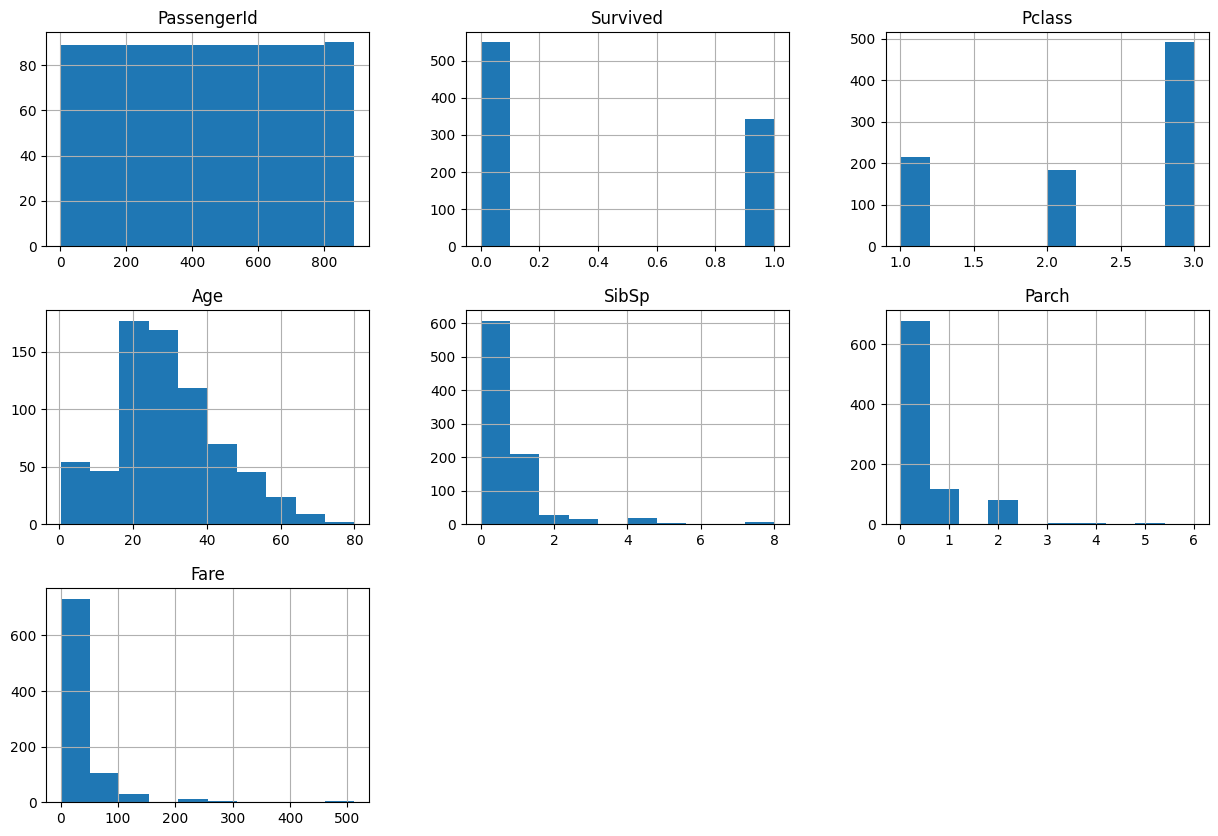

In [7]:
df.hist(figsize=(15, 10));

In [8]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


What is the percentage of males and females?

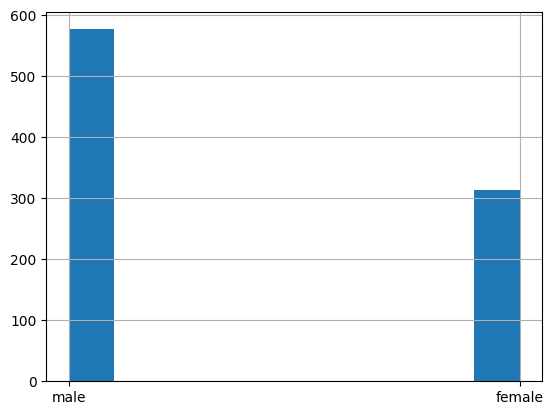

In [9]:
df["Sex"].hist();

In [10]:
print("Sex")
print(f"male : {len(df.loc[df['Sex'] == 'male']) / len(df) * 100:.2f}%")
print(f"female : {len(df.loc[df['Sex'] == 'female']) / len(df) * 100:.2f}%")

Sex
male : 64.76%
female : 35.24%


How could we make a train sample that represents Pclass?

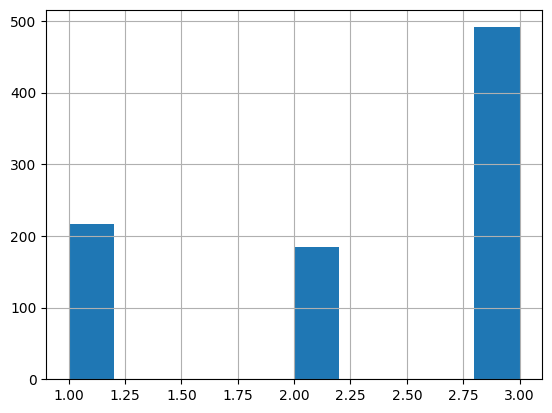

In [11]:
df["Pclass"].hist();

In [12]:
print("Pclass")
print(f"1 : {len(df.loc[df['Pclass'] == 1]) / len(df) * 100:.2f}%")
print(f"2 : {len(df.loc[df['Pclass'] == 2]) / len(df) * 100:.2f}%")
print(f"3 : {len(df.loc[df['Pclass'] == 3]) / len(df) * 100:.2f}%")

Pclass
1 : 24.24%
2 : 20.65%
3 : 55.11%


# Train test split

In [13]:
# Keeping the sex and class proportion while spliting
strat = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
for x, y in strat.split(df, df[["Sex", "Pclass"]]):
    strat_train_set = df.loc[x]
    strat_test_set = df.loc[y]

In [14]:
df = strat_train_set.copy()

# Transforming and encoding

In [15]:
class BaseTransformer(BaseEstimator, TransformerMixin):
    
    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X=None, y=None):
        return self

In [16]:
class DropIds(BaseTransformer):
    
    def transform(self, df):
        df = df.drop(columns=["PassengerId", "Name", "Cabin", "Ticket"])
        return df

In [17]:
class SexEncode(BaseTransformer):
    
    def transform(self, df):
        df["Sex"] = np.where(df["Sex"] == "male", 0, 1)
        return df

In [18]:
class FillNa(BaseTransformer):
    
    def transform(self, df):
        imputer = SimpleImputer(strategy="median")
        imputed_data = imputer.fit_transform(df.drop(columns="Embarked"))
        df = pd.DataFrame(imputed_data, index=df.drop(columns="Embarked").index,
                          columns=df.drop(columns="Embarked").columns)
        return df

In [19]:
# Removing ids
df = DropIds().transform(df)
# Encode sex info
df = SexEncode().transform(df)
# Filling NaN
df = FillNa().transform(df)

# Correlation

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 805 to 261
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    float64
 1   Pclass    712 non-null    float64
 2   Sex       712 non-null    float64
 3   Age       712 non-null    float64
 4   SibSp     712 non-null    float64
 5   Parch     712 non-null    float64
 6   Fare      712 non-null    float64
dtypes: float64(7)
memory usage: 44.5 KB


In [21]:
df.corr(method="spearman")

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.000000,-0.358133,0.544788,-0.019895,0.073417,0.125206,0.324399
Pclass,-0.358133,1.000000,-0.134958,-0.312155,-0.050675,-0.032008,-0.670572
Sex,0.544788,-0.134958,1.000000,-0.065122,0.179773,0.236033,0.247982
Age,-0.019895,-0.312155,-0.065122,1.000000,-0.142633,-0.209777,0.118239
SibSp,0.073417,-0.050675,0.179773,-0.142633,1.000000,0.443331,0.463708
Parch,0.125206,-0.032008,0.236033,-0.209777,0.443331,1.000000,0.410979
Fare,0.324399,-0.670572,0.247982,0.118239,0.463708,0.410979,1.000000


In [22]:
print("Testing columns correlation with Survived")
print("----------------------------------------------------------")
for col in df.columns:
    stat, p = spearmanr(df["Survived"], df[col])
    print(f"{col :>12} | correlation p-value: {p}")

Testing columns correlation with Survived
----------------------------------------------------------
    Survived | correlation p-value: 0.0
      Pclass | correlation p-value: 5.696393937019063e-23
         Sex | correlation p-value: 2.8371713708089446e-56
         Age | correlation p-value: 0.5961234729896203
       SibSp | correlation p-value: 0.05020430035253951
       Parch | correlation p-value: 0.0008133396866128168
        Fare | correlation p-value: 6.557891334993776e-19


There is no significant correlation between survival and age

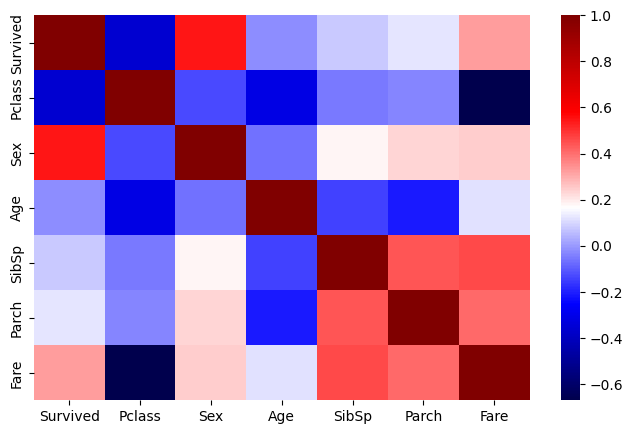

In [23]:
# Visualizing correlations
plt.figure(figsize=(8, 5))
sns.heatmap(df.corr(method="spearman"), cmap="seismic")
plt.show()

# Feature engineering

In [24]:
class FeatureFamilySize(BaseTransformer):
    
    def transform(self, df):
        df["FamilySize"] = df["SibSp"] + df["Parch"]
        df = df.drop(columns=["SibSp", "Parch"])
        return df

In [25]:
class DropAge(BaseTransformer):
    
    def transform(self, df):
        df = df.drop(columns="Age")
        return df

In [26]:
# Replace SibSp and Parch with family size
df = FeatureFamilySize().transform(df)
# Drop age (no relevant correlation)
df = DropAge().transform(df)

In [27]:
print("Testing columns correlation with Survived")
print("----------------------------------------------------------")
for col in df.columns:
    stat, p = spearmanr(df["Survived"], df[col])
    print(f"{col :>12} | correlation p-value: {p}")

Testing columns correlation with Survived
----------------------------------------------------------
    Survived | correlation p-value: 0.0
      Pclass | correlation p-value: 5.696393937019063e-23
         Sex | correlation p-value: 2.8371713708089446e-56
        Fare | correlation p-value: 6.557891334993776e-19
  FamilySize | correlation p-value: 6.692706899753339e-05


In [28]:
df.corr(method="spearman")

,Survived,Pclass,Sex,Fare,FamilySize
Survived,1.000000,-0.358133,0.544788,0.324399,0.148846
Pclass,-0.358133,1.000000,-0.134958,-0.670572,-0.097246
Sex,0.544788,-0.134958,1.000000,0.247982,0.277522
Fare,0.324399,-0.670572,0.247982,1.000000,0.547411
FamilySize,0.148846,-0.097246,0.277522,0.547411,1.000000


All features now have significant correlation with survival

# Pipeline

Defining new data transformation pipeline

In [30]:
# Expected strutcture after pipeline
df.head()

,Survived,Pclass,Sex,Fare,FamilySize
805,0.0,3.0,0.0,7.7750,0.0
344,0.0,2.0,0.0,13.0000,0.0
132,0.0,3.0,1.0,14.5000,1.0
28,1.0,3.0,1.0,7.8792,0.0
55,1.0,1.0,0.0,35.5000,0.0


In [31]:
# Structure from csv
strat_test_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
866,867,1,2,"Duran y More, Miss. Asuncion",female,27.0,1,0,SC/PARIS 2149,13.8583,NaN,C
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
317,318,0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S
239,240,0,2,"Hunt, Mr. George Henry",male,33.0,0,0,SCO/W 1585,12.2750,NaN,S
724,725,1,1,"Chambers, Mr. Norman Campbell",male,27.0,1,0,113806,53.1000,E8,S


In [32]:
pipeline = Pipeline([
    ("drop_id", DropIds()),
    ("encode_sex", SexEncode()),
    ("fillna", FillNa()),
    ("family_size", FeatureFamilySize()),
    ("age_drop", DropAge())
])

In [33]:
df_test = pipeline.fit_transform(strat_test_set)
df_test.head()

,Survived,Pclass,Sex,Fare,FamilySize
866,1.0,2.0,1.0,13.8583,1.0
258,1.0,1.0,1.0,512.3292,0.0
317,0.0,2.0,0.0,14.0000,0.0
239,0.0,2.0,0.0,12.2750,0.0
724,1.0,1.0,0.0,53.1000,1.0


Pipeline implemented!

# Training models

In [34]:
# Training dataset
df_train = pipeline.fit_transform(strat_train_set)
x_train = df_train.drop(columns="Survived")
y_train = df_train["Survived"]

In [35]:
# Test dataset
df_test = pipeline.fit_transform(strat_test_set)
x_test = df_test.drop(columns="Survived")
y_test = df_test["Survived"]

## Random forest

In [36]:
# Model
rfmodel = RandomForestClassifier()
rfmodel.fit(x_train, y_train)

RandomForestClassifier()

In [37]:
# Accuracy testing
predictions = rfmodel.predict(x_train)
acc = accuracy_score(y_train, predictions)
acc

0.9213483146067416

## K nearest neighbors

In [38]:
knmodel = KNeighborsClassifier()
knmodel.fit(x_train, y_train)

KNeighborsClassifier()

In [39]:
# Accuracy testing
predictions = knmodel.predict(x_train)
acc = accuracy_score(y_train, predictions)
acc

0.8469101123595506

## Support vector

In [40]:
svmodel = SVC()
svmodel.fit(x_train, y_train)

SVC()

In [41]:
# Accuracy testing
predictions = svmodel.predict(x_train)
acc = accuracy_score(y_train, predictions)
acc

0.6867977528089888

## Decision tree

In [42]:
dtmodel = DecisionTreeClassifier()
dtmodel.fit(x_train, y_train)

DecisionTreeClassifier()

In [43]:
# Accuracy testing
predictions = dtmodel.predict(x_train)
acc = accuracy_score(y_train, predictions)
acc

0.9213483146067416

# Cross validation

In [44]:
def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Accuracy: {scores.mean()}")
    print(f"Standard deviation: {scores.std()}")

## Random forest

In [45]:
rf_scores = cross_val_score(rfmodel, x_train, y_train,
                            scoring="accuracy", cv=10)
display_scores(rf_scores)

Scores: [0.80555556 0.83333333 0.73239437 0.77464789 0.78873239 0.76056338
 0.8028169  0.84507042 0.81690141 0.77464789]
Accuracy: 0.7934663536776212
Standard deviation: 0.032524163882154726


## K nearest neighbors

In [46]:
kn_scores = cross_val_score(knmodel, x_train, y_train,
                            scoring="accuracy", cv=10)
display_scores(kn_scores)

Scores: [0.76388889 0.75       0.70422535 0.74647887 0.77464789 0.73239437
 0.77464789 0.87323944 0.71830986 0.71830986]
Accuracy: 0.755614241001565
Standard deviation: 0.04550484014890801


## SVC

In [47]:
svc_scores = cross_val_score(svmodel, x_train, y_train,
                            scoring="accuracy", cv=10)
display_scores(svc_scores)

Scores: [0.68055556 0.63888889 0.70422535 0.56338028 0.66197183 0.70422535
 0.67605634 0.64788732 0.74647887 0.71830986]
Accuracy: 0.6741979655712051
Standard deviation: 0.04835966019233052


## Decision tree

In [48]:
dt_scores = cross_val_score(dtmodel, x_train, y_train,
                            scoring="accuracy", cv=10)
display_scores(dt_scores)

Scores: [0.80555556 0.86111111 0.71830986 0.76056338 0.76056338 0.74647887
 0.8028169  0.85915493 0.87323944 0.76056338]
Accuracy: 0.7948356807511736
Standard deviation: 0.05154950718909777


Random forests seems to be the best ones

# Tuning random forests

In [49]:
rfc = RandomForestClassifier(random_state=42)

In [50]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, 40, 50, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10]
}

In [55]:
grid_search = GridSearchCV(rfc, param_grid, cv=5,
                           scoring="accuracy", return_train_score=True)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 20, 30, 40, 50, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                         'min_samples_split': [1, 2, 5, 10],
                         'n_estimators': [50, 100, 150, 200]},
             return_train_score=True, scoring='accuracy')

In [57]:
# Final model
model = grid_search.best_estimator_

In [61]:
# Validation
scores = cross_val_score(model, x_train, y_train,
                         scoring="accuracy", cv=10)
display_scores(scores)

Scores: [0.77777778 0.84722222 0.71830986 0.85915493 0.85915493 0.77464789
 0.78873239 0.83098592 0.85915493 0.81690141]
Accuracy: 0.8132042253521128
Standard deviation: 0.04490759297963933


This is the best accuracy score

# Results

In [62]:
df_new_data = pd.read_csv("data/test.csv")
df_new_data = pipeline.fit_transform(df_new_data)
df_new_data.head()

,Pclass,Sex,Fare,FamilySize
0,3.0,0.0,7.8292,0.0
1,3.0,1.0,7.0000,1.0
2,2.0,0.0,9.6875,0.0
3,3.0,0.0,8.6625,0.0
4,3.0,1.0,12.2875,2.0


In [63]:
model.fit(x_train, y_train)
pred = model.predict(df_new_data)

It would be a good idea doing various models consensus analysis, seeing values that they disagree and picking the most predicted values between them.

In [65]:
# Output to csv file
id = [i for i in range (892, 1310)]
survival = pred.astype(np.int32)
results = pd.DataFrame(list(zip(id, survival)), columns=["PassengerId", "Survived"])
results.to_csv("predictions.csv", index=False)

In [66]:
# !kaggle competitions submit -c titanic -f predictions.csv -m "Fine tuned random forest"

Successfully submitted to Titanic - Machine Learning from Disaster



  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 14.3kB/s]
100%|##########| 3.18k/3.18k [00:02<00:00, 1.22kB/s]
